In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 24
batch_size = 100
input_size = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.001
epochs = 100
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("../data/clean_woodland_data.csv")
df.shape

(25650, 2)

In [6]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-24]
test = df.iloc[-24:]

In [7]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [8]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7620833e+00,
        4.1058330e-01, 0.0000000e+00],
       [7.4316670e-01, 0.0000000e+00, 0.0000000e+00, ..., 5.4612500e+00,
        2.7620833e+00, 4.1058330e-01],
       [4.3818335e+00, 7.4316670e-01, 0.0000000e+00, ..., 8.3561670e+00,
        5.4612500e+00, 2.7620833e+00],
       ...,
       [1.1980000e-02, 0.0000000e+00, 1.5033335e-01, ..., 2.9400000e-03,
        1.9600000e-03, 9.8000000e-04],
       [2.3960000e-02, 1.1980000e-02, 0.0000000e+00, ..., 3.9200000e-03,
        2.9400000e-03, 1.9600000e-03],
       [3.5940000e-02, 2.3960000e-02, 1.1980000e-02, ..., 4.9000000e-03,
        3.9200000e-03, 2.9400000e-03]])

In [9]:
new_df.shape

(25602, 25)

In [10]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [11]:
X.shape, y.shape

((25602, 24), (25602,))

In [12]:
split_index = int(len(X) * 0.9)

In [13]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23041, 24), (2561, 24), (23041,), (2561,))

In [14]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23041, 24, 1), (2561, 24, 1), (23041, 1), (2561, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([23041, 24, 1]),
 torch.Size([2561, 24, 1]),
 torch.Size([23041, 1]),
 torch.Size([2561, 1]))

In [16]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [17]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [18]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 24, 1]) torch.Size([100, 1])


## Custom Model

In [20]:
class CustomUnit(nn.Module):



    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # input weight
        self.W_i = nn.Parameter(torch.Tensor(input_size, hidden_size), requires_grad = True)

        # forget gate
        self.W_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size), requires_grad = True)
        self.U_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size), requires_grad = True)
        self.b_f = nn.Parameter(torch.Tensor(hidden_size), requires_grad = True)

        self.init_weights()

    def init_weights(self):
        for weight in self.parameters():
            if weight.data.ndimension() < 2:  # Bias or 1D weights
                nn.init.zeros_(weight)
            else:
                nn.init.xavier_uniform_(weight)



    def forward(self, x, hidden = None):

        bs, seq, ip = x.size()
        hidden_seq = []

        if hidden is None:
            h_prev, c_prev = (
                torch.zeros(bs, self.hidden_size).to(device),
                torch.zeros(bs, self.hidden_size).to(device),
            )
        else:
            h_prev, c_prev = hidden

        for t in range(seq):
            x_t = x[:, t, :]
            x_t = torch.tanh(x_t @ self.W_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_prev @ self.U_f + self.b_f) 
            h_t = (f_t * h_prev) + ((1 - f_t) * x_t)
            c_t = c_prev
            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim = 0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class CustomNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.custom_layer = CustomUnit(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.custom_layer(x)
        out = F.relu(self.fc(x_[:, -1, :]))
        return out   

In [21]:
rnnnet = CustomNet(input_size, hidden_size, num_classes).to(device)
rnnnet_optimizer = torch.optim.Adam(rnnnet.parameters(), lr = learning_rate)

In [22]:
total_rnnnet_parameters = count_parameters(rnnnet)

In [23]:
rnnnet_train_loss_array = []
rnnnet_val_loss_array = []

In [24]:
rnnnet_start_time = time.time()
train_and_validate(epochs, device, rnnnet, train_loader, val_loader, criterion, rnnnet_optimizer, rnnnet_train_loss_array, rnnnet_val_loss_array)
rnnnet_end_time = time.time()
rnnnet_total_training_time = rnnnet_end_time - rnnnet_start_time
rnnnet_avg_training_time_per_epoch = rnnnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 7.216345283892248 | Validation Loss: 2.6819934519186903
Epoch no.: 2 | Training Loss: 3.8393688093532217 | Validation Loss: 2.729956119178006
Epoch no.: 3 | Training Loss: 3.753764619042863 | Validation Loss: 2.743121610703663
Epoch no.: 4 | Training Loss: 3.7279884113377824 | Validation Loss: 2.7582283433741677
Epoch no.: 5 | Training Loss: 3.7174893581505977 | Validation Loss: 2.749860394996806
Epoch no.: 6 | Training Loss: 3.695292492449542 | Validation Loss: 2.7518820276555536
Epoch no.: 7 | Training Loss: 3.6920957395008633 | Validation Loss: 2.714859184737389
Epoch no.: 8 | Training Loss: 3.6843385858969255 | Validation Loss: 2.7361311764957814
Epoch no.: 9 | Training Loss: 3.6779113156454906 | Validation Loss: 2.7298214583872604
Epoch no.: 10 | Training Loss: 3.657842417816063 | Validation Loss: 2.7391113797919107
Epoch no.: 11 | Training Loss: 3.6473958812234724 | Validation Loss: 2.6912735790873947
Epoch no.: 12 | Training Loss: 3.6466593186318614

In [25]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     RNN: {total_rnnnet_parameters}")
print()
print(f"Total Training Time:     RNN: {rnnnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     RNN: {rnnnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     RNN: 20301

Total Training Time:     RNN: 512.61s

Average Training Time Per Epoch:     RNN: 5.13s
------------------------------------------------------------


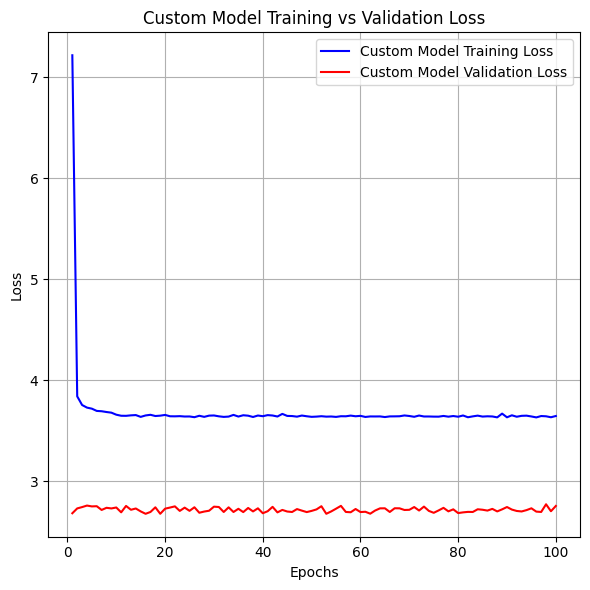

In [26]:
plot_loss_comparison(epochs, rnnnet_train_loss_array, rnnnet_val_loss_array, "Custom Model Training Loss", "Custom Model Validation Loss", "Custom Model Training vs Validation Loss")

In [27]:
rnnnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = rnnnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_980\1549511991.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


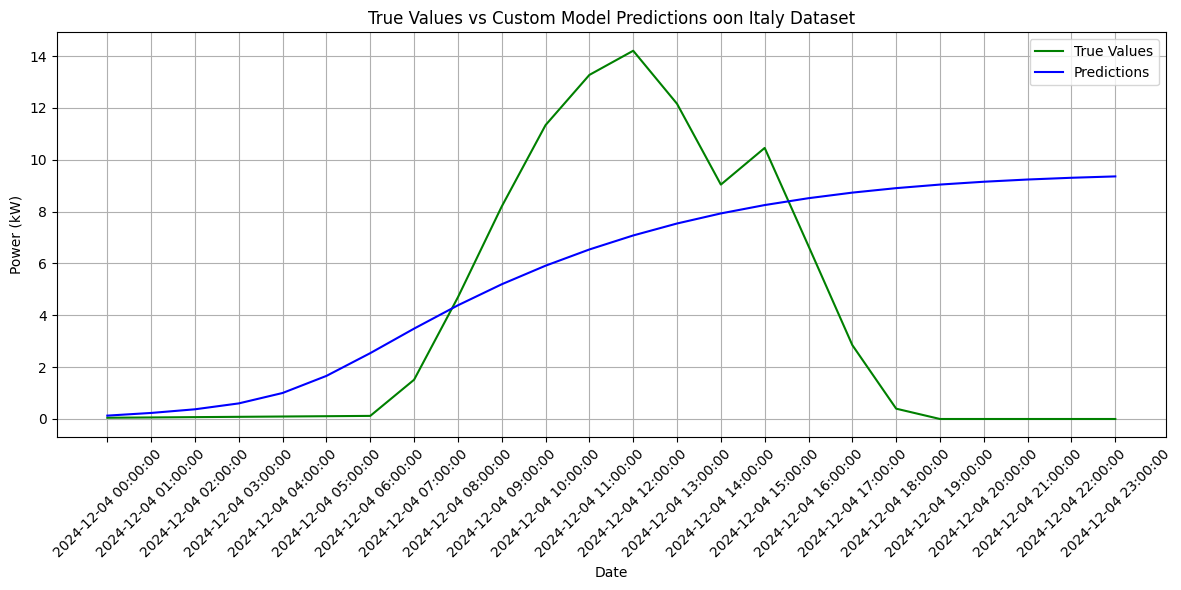

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs Custom Model Predictions oon Italy Dataset')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared value: {r2}')

Root Mean Squared Error: 5.442387631351043
R-squared value: -0.16403540873229394
